In [1]:
%load_ext autoreload
%autoreload 2
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load models

In [2]:
from classification.models.M5 import M5PLModule
from classification.models.CRNN import CRNNPLModule
from classification.models.SpectrogramCNN import SpectrogramCNNPLModule
from classification.models.DeepRecursiveCNN import DeepRecursiveCNNPLModule

models = {}

In [3]:
loaded_dict = torch.load("/nfs/students/summer-term-2020/project-4/SAVED_MODELS/M5/M5_vanilla.p")
hparams = loaded_dict["hparams"]
hparams['batch_size'] = 30

model = M5PLModule(hparams)
model.model.load_state_dict(loaded_dict["state_dict"])
model = model.eval().cuda()

models[model.__class__.__name__] = model

In [4]:
state_dict_path = '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/SpectrogramCNN/optuna_90.5.p'
loaded_dict = torch.load(state_dict_path)
loaded_dict['hparams']['batch_size'] = 5
model = SpectrogramCNNPLModule(loaded_dict['hparams'])
model.model.load_state_dict(loaded_dict['state_dict'])
model = model.cuda()
model = model.eval()

models[model.__class__.__name__] = model

In [5]:
model_state_dict_path = "/nfs/students/summer-term-2020/project-4/yan/models/best_model_state_dict.pt"

hparams = {
    "batch_size": 2,
    "learning_rate": 0.001,
    "weight_decay": 0,
    "lr_decay": 1
}

model = DeepRecursiveCNNPLModule(hparams)
model.model.load_state_dict(torch.load(model_state_dict_path))
model = model.eval()

models[model.__class__.__name__] = model

In [ ]:
state_dict_path = '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/CRNN/crnn_0.879.p'

loaded_dict = torch.load(state_dict_path)

model = CRNNPLModule(loaded_dict['hparams'])
model.model.load_state_dict(loaded_dict['state_dict'])
model = model.eval().cuda()

models[model.__class__.__name__] = model

In [37]:
loaded_dict

{'state_dict': OrderedDict([('spec.spectrogram.window',
               tensor([0.0000e+00, 2.3544e-06, 9.4175e-06,  ..., 2.1189e-05, 9.4175e-06,
                       2.3544e-06], device='cuda:0')),
              ('spec.mel_scale.fb',
               tensor([[-0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
                        0.0000e+00],
                       [8.0991e-01, 1.9009e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
                        0.0000e+00],
                       [0.0000e+00, 6.5669e-01, 3.4331e-01,  ..., 0.0000e+00, 0.0000e+00,
                        0.0000e+00],
                       ...,
                       [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
                        6.9657e-02],
                       [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
                        3.4830e-02],
                       [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          

In [7]:
#fast_model = {'SpectrogramCNNPLModule': models['SpectrogramCNNPLModule']}

# Load Data

In [8]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

In [9]:
for model_name in models:
    #datasetHandler.load(models[model_name], 'training')
    datasetHandler.load(models[model_name], 'validation')
    #datasetHandler.load(models[model_name], 'testing')

Loading cached validation data of dataset 0 from /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_8k/
Loading cached validation data of dataset 0 from /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_48k/


# Attacks

## Functional Attacks

In [ ]:
from attacks.functionalVolume import FunctionalVolumeAttack

attack_parameters = {'epsilonVolume': 0.1, 'epsilonPGD': 0.001, 'num_iter': 10}
attacks = {}

for model_name in models:
    valid_loader = models[model_name].val_dataloader()
    fva = FunctionalVolumeAttack(model, valid_loader, attack_parameters, save_samples=True)
    fva.attack()
    attacks[model_name] = fva
    
for model_name in attacks:
    print(model_name)
    attacks[model_name].report()
    print()

 19%|█▉        | 11/57 [00:12<00:52,  1.14s/it]

## FGSM

In [10]:
from attacks.pgd import ProjectedGradientDescent

epsilons = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

attacks = {}
for model_name in models:
    for eps in epsilons:
        attack_parameters = {'epsilon': eps, 'num_iter': 1}
        valid_loader = models[model_name].val_dataloader()
        fgsm = ProjectedGradientDescent(models[model_name], valid_loader, attack_parameters, save_samples=True)
        fgsm.attack()
        attacks.setdefault(model_name, []).append(fgsm)

100%|██████████| 71/71 [00:34<00:00,  2.07it/s]


In [11]:
for model_name in attacks:
    print(model_name)
    print(attacks[model_name][0].report())
    print()

M5PLModule
Attack-Parameters:	{'epsilon': 0, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1440
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.85
{'success_rate': 0.0, 'acc': 0.8535862477771191}

SpectrogramCNNPLModule
Attack-Parameters:	{'epsilon': 0, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1524
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.9
{'success_rate': 0.0, 'acc': 0.9033787788974511}

DeepRecursiveCNNPLModule
Attack-Parameters:	{'epsilon': 0, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1503
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.89
{'success_rate': 0.0, 'acc': 0.8909306461173682}

CRNNPLModule
Attack-Parameters:	{'epsilon': 0, 'num_iter': 1}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1484
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.88

In [12]:
from utils.Visual import draw_plot 

In [25]:
show_max = 9

In [27]:
#colors = ['r', 'b', 'grey', 'g']
y = []
for i in range(len(attacks)):
    model_name = list(attacks.keys())[i]
    y_i = {'data': [attack.getAccuracy() for attack in attacks[model_name]][:show_max]}
    #y_i['color'] = colors[i]
    y_i['label'] = model_name[:-8]
    if y_i['label'] == 'M5':
        y_i['label'] = "FullyConvolutional"
    y.append(y_i)

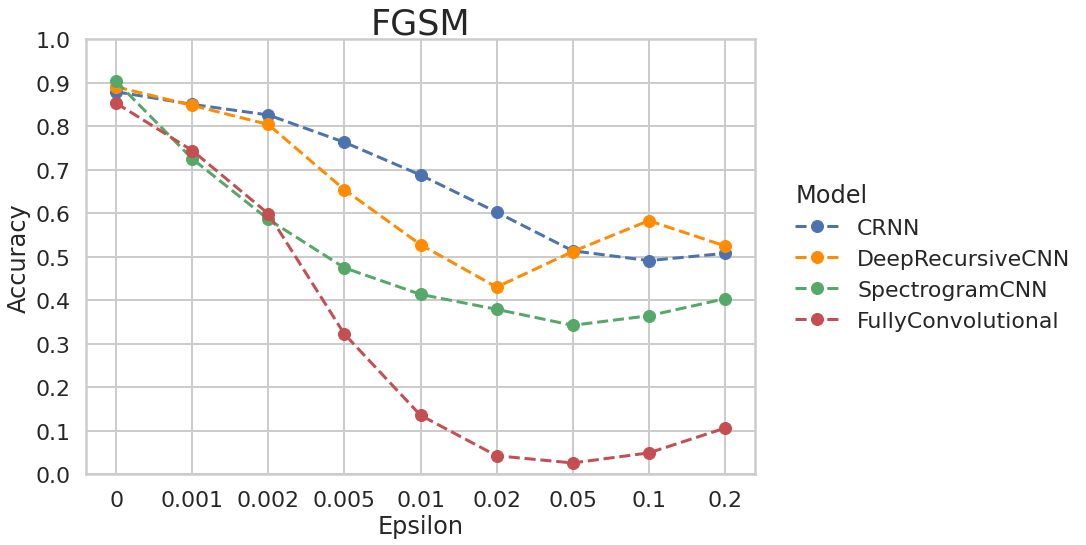

In [34]:
y[0]['color'], y[1]['color'], y[2]['color'], y[3]['color'] = 'r', 'g', 'darkorange', 'b'
draw_plot(epsilons[:show_max], data = reversed(y), legend_x_offset=1.5, title="FGSM",
          legend_title="Model", x_label="Epsilon", y_label="Accuracy", context="poster")